Feature Engineering inspired by [DEEPAK KAURA](https://www.kaggle.com/code/deepakkaura/spaceship-titanic-story-of-a-space-titanic)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


### Importing Data

In [2]:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

train = train_df.copy()
test = test_df.copy()
sample = sample_df.copy()
train_test = pd.concat([train,test],axis=0,ignore_index=True)

### EDA & Feature Engineering

<AxesSubplot:>

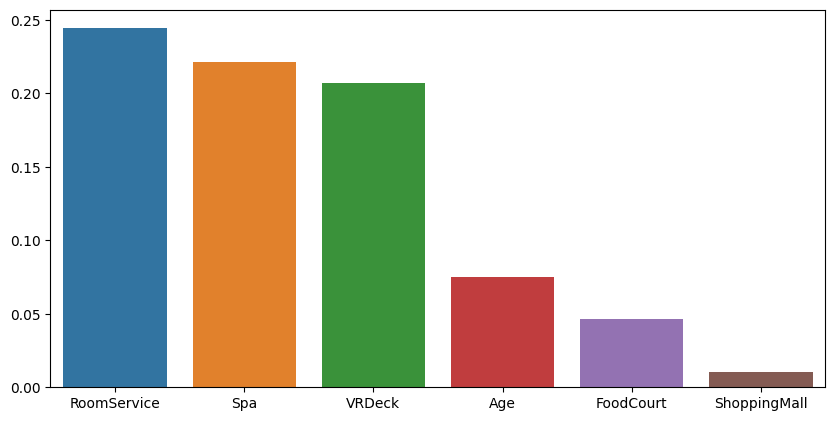

In [3]:
num_fea_imp = train.corr().Transported.abs().sort_values(ascending=False).drop('Transported',axis=0)
plt.figure(figsize=(10,5),dpi=100)
sns.barplot(x=num_fea_imp.index,y=num_fea_imp.values)

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
# Transported - about half were transported
train.Transported.sum()/len(train)

# PaggenserID - No overlap of Passenger Groups between train and test data

train['PassengerGroup'] = train.PassengerId.str.split('_',expand=True)[0].astype('int')
test['PassengerGroup'] = test.PassengerId.str.split('_',expand=True)[0].astype('int')

len(set(train['PassengerGroup'])) + len(set(test['PassengerGroup'])) - len(set(list(train['PassengerGroup'])+list(test['PassengerGroup'])))

# HomePlanet
train['HomePlanet'] = train['HomePlanet'].fillna(value='Unknown')
test['HomePlanet'] = test['HomePlanet'].fillna(value='Unknown')

# CryoSleep
train['CryoSleep'] = train['CryoSleep'].fillna(value=False)
test['CryoSleep'] = test['CryoSleep'].fillna(value=False)

# Cabin
train['CabinDeck'] = train['Cabin'].str.split('/',expand=True)[0]
test['CabinDeck'] = test['Cabin'].str.split('/',expand=True)[0]
train['CabinDeck'] = train['CabinDeck'].fillna(value='U')
test['CabinDeck'] = test['CabinDeck'].fillna(value='U')

train['CabinSide'] = train['Cabin'].str.split('/',expand=True)[2]
test['CabinSide'] = test['Cabin'].str.split('/',expand=True)[2]
train['CabinSide'] = train['CabinSide'].fillna(value='U')
test['CabinSide'] = test['CabinSide'].fillna(value='U')

# Destination
dest_dic = {'TRAPPIST-1e':'A','55 Cancri e':'B','PSO J318.5-22':'C'}
train['Destination'] = train['Destination'].map(dest_dic)
train['Destination'] = train['Destination'].fillna(value='U')
test['Destination'] = test['Destination'].map(dest_dic)
test['Destination'] = test['Destination'].fillna(value='U')

# Age
train['Age'] = train['Age'].fillna(train.groupby('PassengerGroup')['Age'].transform('median'))
train['Age'] = train['Age'].fillna(train.groupby('HomePlanet')['Age'].transform('median'))

test['Age'] = test['Age'].fillna(test.groupby('PassengerGroup')['Age'].transform('median'))
test['Age'] = test['Age'].fillna(test.groupby('HomePlanet')['Age'].transform('median'))

train['Adult'] = 1
train.loc[train['Age']<18, 'Adult'] = 0

test['Adult'] = 1
test.loc[test['Age']<18, 'Adult'] = 0

# VIP
train['VIP'] = train['VIP'].fillna(value=False)
test['VIP'] = test['VIP'].fillna(value=False)

# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(value=0)
test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(value=0)

# Total Spend
train['TotalSpend'] = train['RoomService']+train['FoodCourt']+train['ShoppingMall']+train['Spa']+train['VRDeck']
test['TotalSpend'] = test['RoomService']+test['FoodCourt']+test['ShoppingMall']+test['Spa']+test['VRDeck']

# Name
train['FamilyName'] = train['Name'].str.split(' ',expand=True)[1]
train['FamilyName'] = train['FamilyName'].fillna('Unknown')

test['FamilyName'] = test['Name'].str.split(' ',expand=True)[1]
test['FamilyName'] = test['FamilyName'].fillna('Unknown')

train_test['FamilyName'] = train_test['Name'].str.split(' ',expand=True)[1]
train_test['FamilyName'] = train_test['FamilyName'].fillna('Unknown')

family_name_dic = train_test['FamilyName'].value_counts().to_dict()
family_name_dic['Unknown'] = 0

train['FamilyMember'] = train['FamilyName']
train['FamilyMember'] = train['FamilyMember'].map(family_name_dic)

test['FamilyMember'] = test['FamilyName']
test['FamilyMember'] = test['FamilyMember'].map(family_name_dic)

# Drop extra columns

train = train.drop(['PassengerId','PassengerGroup','Cabin','Name','FamilyName'],axis=1)
test = test.drop(['PassengerId','PassengerGroup','Cabin','Name','FamilyName'],axis=1)

# Convert Bool to Int
train[['CryoSleep','VIP','Transported']] = train[['CryoSleep','VIP','Transported']].astype(int)
test[['CryoSleep','VIP']] = test[['CryoSleep','VIP']].astype(int)

In [6]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinSide,Adult,TotalSpend,FamilyMember
0,Europa,0,A,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,P,1,0.0,3
1,Earth,0,A,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,S,1,736.0,4
2,Europa,0,A,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,S,1,10383.0,7
3,Europa,0,A,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,S,1,5176.0,7
4,Earth,0,A,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,S,0,1091.0,9


In [7]:
# Feature Scaling
num_features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpend','FamilyMember']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_num_scaled = scaler.fit_transform(train[num_features])
test_num_scaled = scaler.transform(test[num_features])

train_num_scaled = pd.DataFrame(data=train_num_scaled,columns=num_features)
test_num_scaled = pd.DataFrame(data=test_num_scaled,columns=num_features)

# Feature Encoding
cat_features = ['HomePlanet','CryoSleep','Destination','VIP','CabinDeck','CabinSide','Adult']

train_cat_encoded = pd.get_dummies(train[cat_features],drop_first=True)
test_cat_encoded = pd.get_dummies(test[cat_features],drop_first=True)

# Train and Test
X = pd.concat([train_num_scaled,train_cat_encoded],axis=1)
X_test = pd.concat([test_num_scaled,test_cat_encoded],axis=1)
y = train.Transported
X_all = pd.concat([X,y],axis=1)

In [8]:
X_all.corr().Transported.abs().sort_values(ascending=False)

Transported           1.000000
CryoSleep             0.460132
RoomService           0.241124
Spa                   0.218545
VRDeck                0.204874
TotalSpend            0.199514
HomePlanet_Europa     0.176916
CabinDeck_B           0.144733
Adult                 0.115822
Destination_B         0.108722
CabinDeck_C           0.108193
CabinSide_S           0.101455
CabinDeck_E           0.097965
CabinDeck_F           0.087753
Age                   0.071340
FamilyMember          0.052706
FoodCourt             0.045583
VIP                   0.037261
CabinDeck_D           0.034046
HomePlanet_Mars       0.019544
CabinDeck_G           0.016269
CabinDeck_T           0.014568
ShoppingMall          0.009391
HomePlanet_Unknown    0.002712
Destination_U         0.000547
CabinDeck_U           0.000340
CabinSide_U           0.000340
Destination_C         0.000092
Name: Transported, dtype: float64

### Modeling

In [9]:
# Train Valid Split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=101)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier

In [11]:
# # Logistic Regression
# print('Running LogisticRegression\n')
# logreg = LogisticRegression(max_iter = 600)
# scores = cross_val_score(logreg,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
# logreg_mse = round(abs(scores.mean()), 4)
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_valid)
# logreg_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)


# # Decision Tree
# print('Running DecisionTreeClassifier\n')
# decision_tree = DecisionTreeClassifier()
# scores = cross_val_score(decision_tree,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
# decision_tree_mse = round(abs(scores.mean()), 4)
# decision_tree.fit(X_train, y_train)
# y_pred = decision_tree.predict(X_valid)
# decision_tree_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# # Random Forest
# print('Running RandomForestClassifier\n')
# random_forest = RandomForestClassifier()
# scores = cross_val_score(random_forest,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
# random_forest_mse = round(abs(scores.mean()), 4)
# random_forest.fit(X_train, y_train)
# y_pred = random_forest.predict(X_valid)
# random_forest_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# # XGBoost
# print('Running XGBClassifier\n')
# xgb = XGBClassifier()
# scores = cross_val_score(xgb,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
# xgb_mse = round(abs(scores.mean()), 4)
# xgb.fit(X_train, y_train)
# y_pred = xgb.predict(X_valid)
# xgb_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# # GB
# print('Running GradientBoostingClassifier\n')
# gb = GradientBoostingClassifier()
# scores = cross_val_score(gb,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
# gb_mse = round(abs(scores.mean()), 4)
# gb.fit(X_train, y_train)
# y_pred = gb.predict(X_valid)
# gb_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# # LightGBM
# print('Running LGBMClassifier\n')
# lgbm = LGBMClassifier()
# scores = cross_val_score(lgbm,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
# lgbm_mse = round(abs(scores.mean()), 4)
# lgbm.fit(X_train, y_train)
# y_pred = lgbm.predict(X_valid)
# lgbm_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# # Catboost
# print('Running CatBoostClassifier\n')
# catb = CatBoostClassifier(verbose = 0)
# scores = cross_val_score(catb,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
# catb_mse = round(abs(scores.mean()), 4)
# catb.fit(X_train, y_train)
# y_pred = catb.predict(X_valid)
# catb_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# # Histogram-based Gradient Boosting Classification Tree
# print('Running HistGradientBoostingClassifier\n')
# hgb = HistGradientBoostingClassifier()
# scores = cross_val_score(hgb,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
# hgb_mse = round(abs(scores.mean()), 4)
# hgb.fit(X_train, y_train)
# y_pred = hgb.predict(X_valid)
# hgb_acc = round(metrics.accuracy_score(y_valid, y_pred), 4)

# model_df = pd.DataFrame({
#     'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'GB', 'LightGBM', 'Catboost', 'HistBoost'],
#     'Train MSE': [logreg_mse, decision_tree_mse, random_forest_mse, xgb_mse, gb_mse, lgbm_mse, catb_mse, hgb_mse],
#     'Validation Accuracy': [logreg_acc, decision_tree_acc, random_forest_acc, xgb_acc, gb_acc, lgbm_acc, catb_acc, hgb_acc]
# })

# print(model_df.sort_values('Validation Accuracy', ascending = False).reset_index(drop = True))

### Grid Search on Catboost

In [12]:
# #  Grid Search on Catboost
# catb = CatBoostClassifier(verbose = 0)
# param_grid = {'iterations':[300,400,500,1000],
#               'learning_rate':[0.01,0.03,0.05,0.07,0.09],
#               'depth':[2,5,10]
#              }

# grid = GridSearchCV(estimator=catb, param_grid=param_grid, cv=5)
# grid.fit(X,y)
# print('Mean accuracy:',grid.score(X,y))
# print('Best hyperparameters:',grid.best_params_)

In [13]:
# Tuned Catboost (LB score: 0.80617)
catb = CatBoostClassifier(depth=5,iterations=300,learning_rate=0.05,verbose=0)

In [14]:
# Submitting
model=catb
model.fit(X,y)
predictions = model.predict(X_test)
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Transported': predictions})
output['Transported'] = output['Transported'].astype('bool')
output.to_csv('submission.csv', index=False)